In [1]:
import sys; sys.path.append('..') # add project root to the python path

In [2]:
import matplotlib.pyplot as plt

from src.part2.async_dp import AsyncDP
from src.common.gridworld import GridworldEnv
from src.common.grid_visualization import visualize_value_function, visualize_policy

## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [3]:
nx = 5
ny = 5
env = GridworldEnv([ny, nx])

## 비동기적 동적계획법 '에이전트' 초기화하기

(비동기적) 동적 계획법은 원래 `에이전트`라는 개념을 사용하지 않지만, 일반적으로 사용되는 강화학습의 구현 템플릿에 대한 이해를 돕기 위해 `에이전트`라는 개념을 적용하였습니다.

```python
class AsyncDP:

    def __init__(self,
                 gamma=1.0,
                 error_tol=1e-5):
        self.gamma = gamma
        self.error_tol = error_tol
        ...
```

`AsyncDP` 클래스는 2개의 파라미터를 받습니다. 
감소율 `gamma` 와 가치평가/반복 알고리즘에서 수렴조건을 확인할 때 사용하는 수치적 에러의 허용치인 `error_tol` 입니다. 이 예제에서는 각각 `1.0` 과 `1e-5`로 설정하겠습니다.

In [4]:
asyncDPagent = AsyncDP()
asyncDPagent.set_env(env)

Asynchronous DP agent initialized
Environment spec:  Num. state = 25 | Num. actions = 4 


## Full sweeping

이전 수업에서 배웠던, 정책평가 (policy evaluation), 가치반복 (value iteration) 모두 매 반복마다 __모든__ $(s)$ 및 $(s,a)$ 에 대해서 업데이트를 했던 사실을 기억하시죠?

이처럼 모든 $(s)$ 및 $(s,a)$에 대해서 업데이트 해주는 방식을 __Full sweeping__ 이라고 부릅니다.
우리도 일단 Full sweeping으로 상태 가치함수를 업데이트한다고 가정하고, 비동기적 동적 계획법을 활용해서 가치 반복 알고리즘들을 수행해볼까요?

## (1) In-place value iteration

`In-place` 라는 이름이 말해주 듯, 하나(!)의 Value function 만을 가지고 가치반복 알고리즘을 수행합니다. '하나'의 value function 만을 가지고 ture / optimal value function 을 추산하는 In-place method는 최적 가치함수에 수렴합니다.

이 알고리즘이 수렴한다는 사실은 매우 중요합니다. 이 사실 덕분에, 차후에 학습기반의 RL기법을 사용할 때도 하나의 Value function 만을 가지고 학습을 해도, 그 결과물이 true value function 에 수렴한다는 것에 대해 이야기 할 수 있게 됩니다. 

>물론, 엄밀하게 말해서는, 수렴하기 위해 '적절한 조건' 필요합니다. 이는 수업에서 서서히 배워보도록 하죠.

`In-place value iteration` 기존의 VI와 정말 유사합니다.

<img src="./images/in_place_vi_full_sweep.png" width="80%" height="50%" title="in_place_vi" alt="Tensor"></img>

비교를 위해서 `value iteration` 도 확인해보죠.

<img src="./images/vi.png" width="80%" height="50%" title="in_place_vi" alt="Tensor"></img>

두 알고리즘의 큰 차이점은<br>
> `Value iteration` 은 $V_k(s)$ 와 $V_k+1(s)$ 을 유지하고, $V_k+1(s)$ 계산할 때 $V_k(s)$을 참조한다. <br>

> `In-place value iteration` 은 $V(s)$만을 유지하고, $V(s')$ 계산할 때 $V(s)$을 참조한다.

입니다.

이제 그럼 `In-place value iteration`의 파이썬 구현체를 살펴볼까요?

```python
def in_place_vi(self, v_init=None):
    """
    :param v_init: (np.array) initial value 'guesstimation' (optional)
    :return:
    """

    if v_init is not None:
        value = v_init
    else:
        value = np.zeros(self.ns)

    info = dict()
    info['v'] = list()
    info['pi'] = list()
    info['converge'] = None
    info['gap'] = list()

    steps = 0

    # loop over value iteration:
    # perform the loop until the value estimates are converge
    while True:
        # loop over states:
        # we perform 'sweeping' over states in "any arbitrary" order.
        # without-loss-of-generality, we can perform as the order of states.
        # in this example, we consider the "full sweeping" of values.

        # perform in-place VI
        delta_v = 0
        info['v'].append(value)
        pi = self.construct_policy_from_v(value)
        info['pi'].append(pi)

        for s in range(self.ns):
            # Bellman expectation backup of current state in in-place fashion
            # get Q values of given state 's'
            
            # output of 'self.compute_q_from_v(value)' is a tensor
            # with the shape of [num. actions X num. states].
            qs = self.compute_q_from_v(value)[:, s]
            
            v = qs.max(axis=0)  # get max value along the actions

            # accumulate the deviation from the current state s
            # the deviation = |v_new - v|
            delta_v += np.linalg.norm(value[s] - v)
            value[s] = v
            
        info['gap'].append(delta_v)

        if delta_v < self.error_tol:
            info['converge'] = steps
            break
        else:
            steps += 1

    return info
```

In [5]:
info_ip_vi = asyncDPagent.in_place_vi()

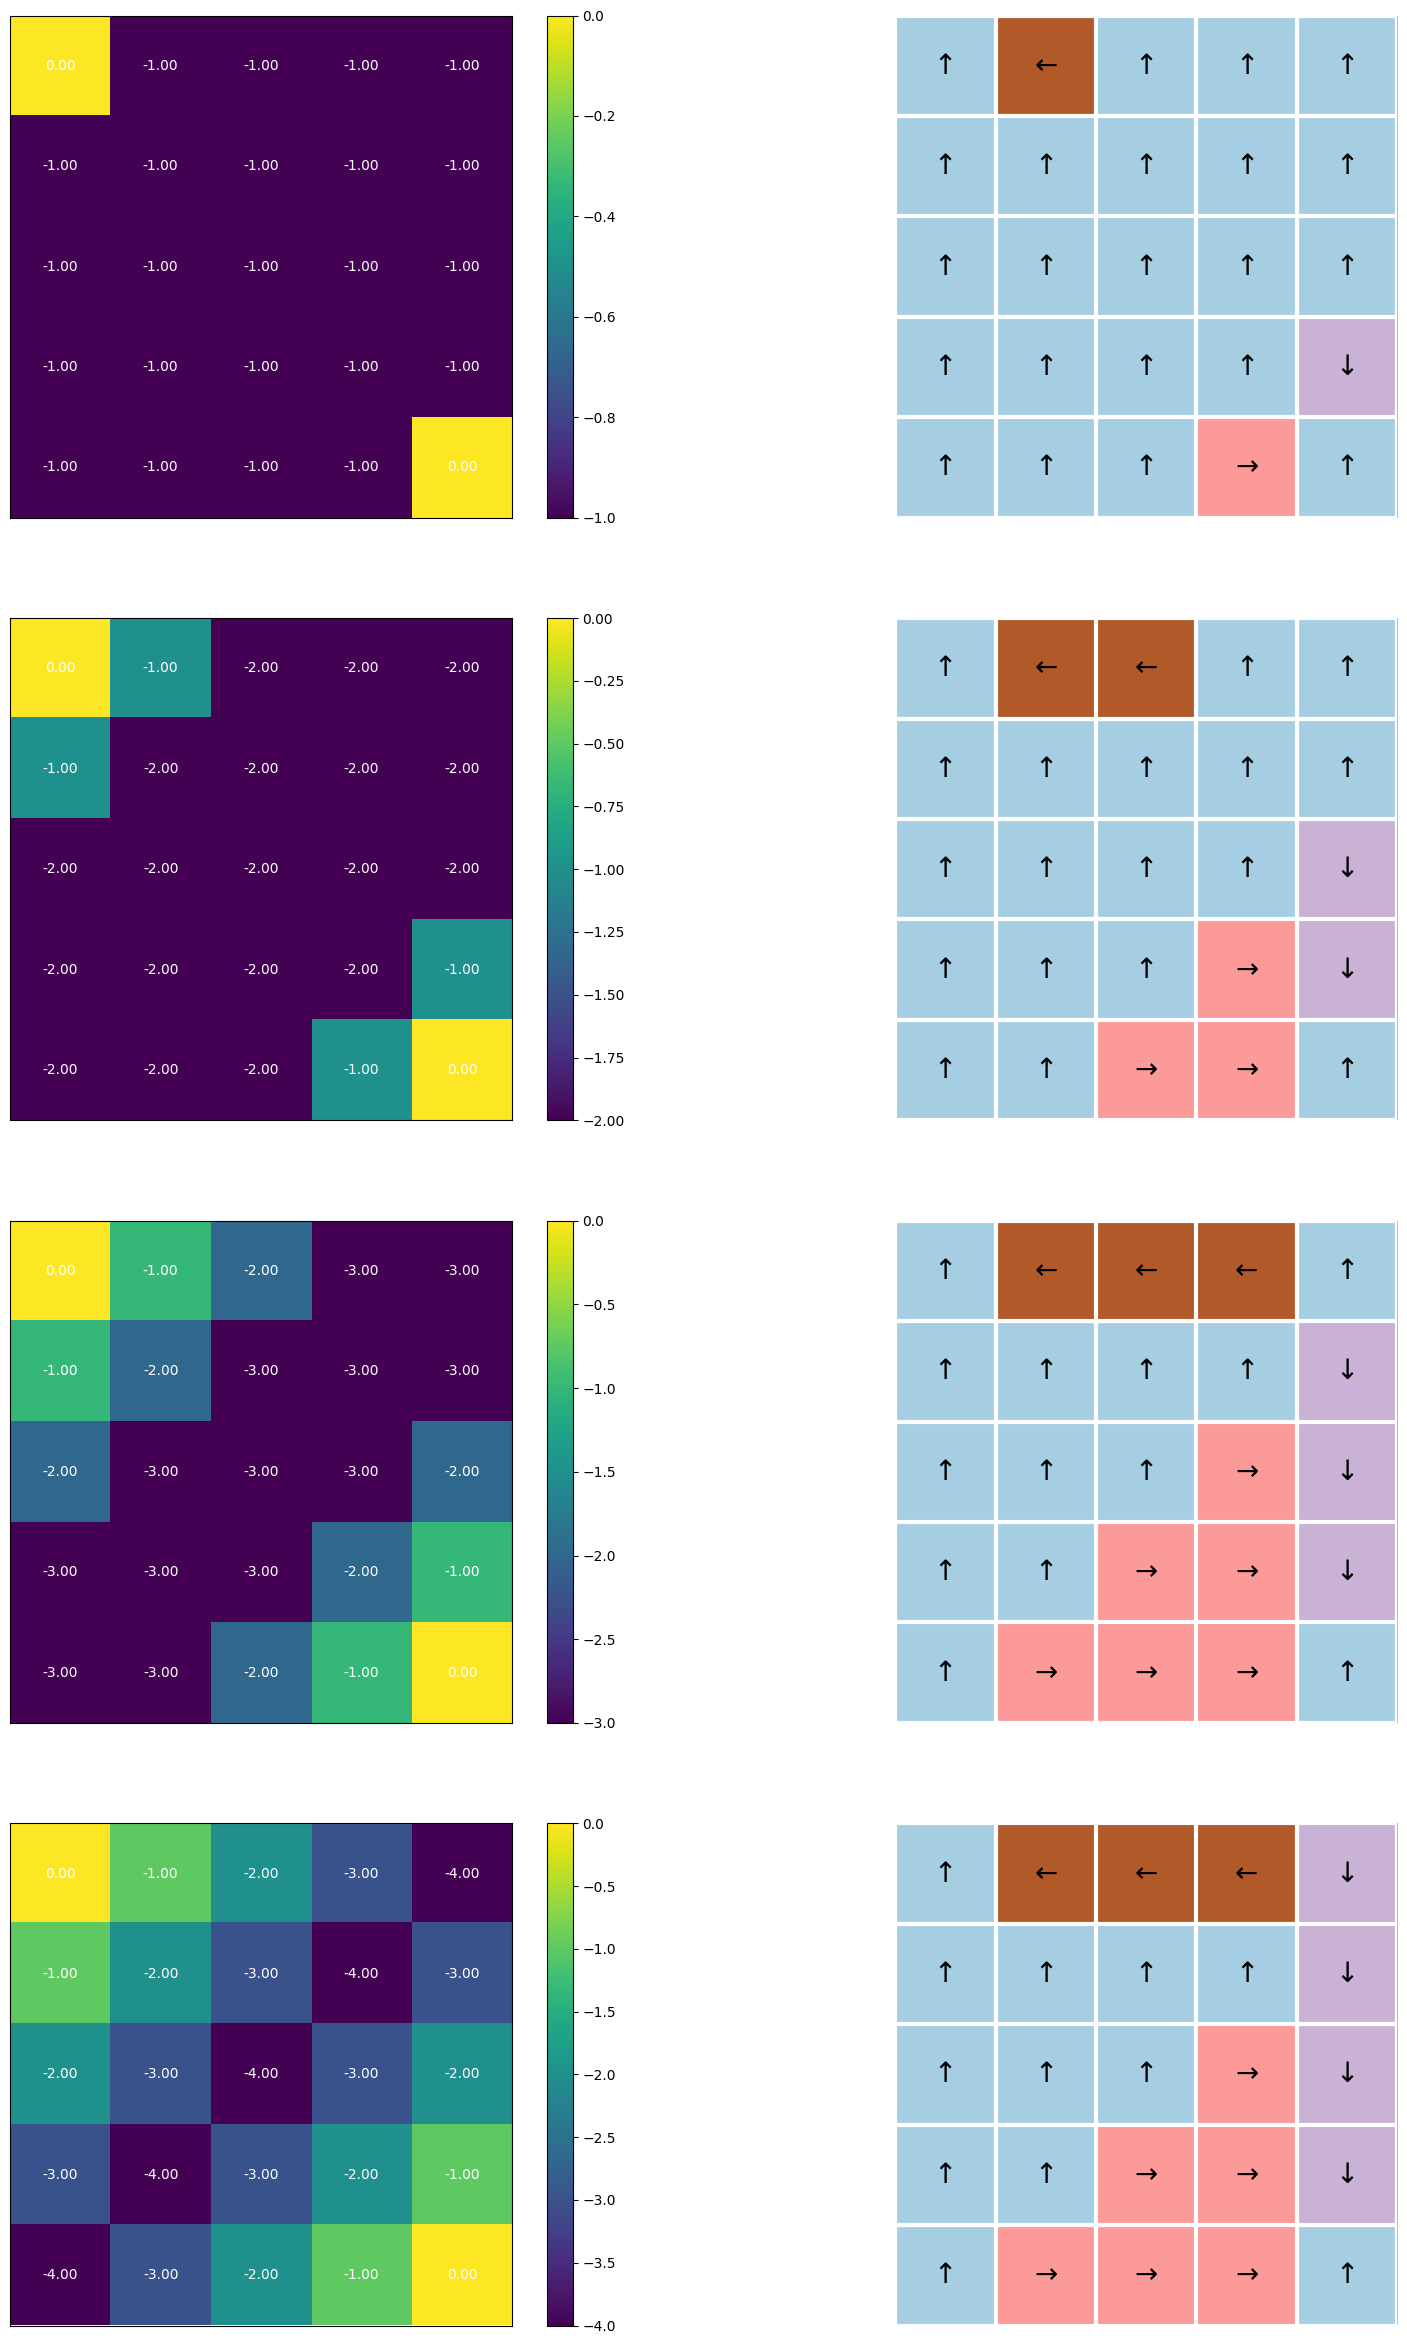

In [6]:
figsize_mul = 10
steps = info_ip_vi['step']

fig, ax = plt.subplots(nrows=steps, ncols=2, 
                       figsize=(steps * figsize_mul * 0.5, figsize_mul* 3))
for i in range(steps):
    visualize_value_function(ax[i][0],info_ip_vi['v'][i], nx, ny)
    visualize_policy(ax[i][1], info_ip_vi['pi'][i], nx, ny)    

## (2) Prioirtized sweeping value iteration

Prioirtized sweeping = 우선순위를 준 (Prioirtized) + 가치값 업데이트하기 (sweeping) 입니다.

> `In-place value iteration` 에서는 임의의 순서 (우리는 환경의 상태 인덱스 순서) 로 가치함수를 업데이트했습니다.

임의의 순서에 대해서 알고리즘이 수렴하니, 그렇다면 혹시 **좀 더 좋은 가치 업데이트 순서**가 없을까요? Prioirtized sweeping은 "Bellman error 의 크기에 비례하는 순서대로 업데이트를 하자"는 알고리즘입니다. Bellman error $e(s)$ 의 정의는 다음과 같습니다.

$$e(s) = |\max_{a \in \cal{A}}(R_s^a+ \gamma \sum_{s'\in \cal{S}} P_{ss'}^a V(s')) - V(s)|$$

`Prioirtized sweeping` 의 파이썬 구현을 살펴보도록 할까요?

```python
def prioritized_sweeping_vi(self, v_init=None):
    """
    :param v_init: (np.array) initial value 'guesstimation' (optional)
    :return:
    """

    if v_init is not None:
        value = v_init
    else:
        value = np.zeros(self.ns)

    info = dict()
    info['v'] = list()
    info['pi'] = list()
    info['converge'] = None
    info['gap'] = list()

    steps = 0
    while True:
        # compute the Bellman errors
        # bellman_errors shape : [num.states]
        bellman_errors = value - (self.R.T + self.P.dot(value)).max(axis=0)
        state_indices = range(self.ns)

        # put the (bellman error, state index) into the priority queue
        priority_queue = PriorityQueue()
        for bellman_error, s_idx in zip(bellman_errors, state_indices):
            priority_queue.put((-bellman_error, s_idx))

        info['v'].append(value)
        pi = self.construct_policy_from_v(value)
        info['pi'].append(pi)
        delta_v = 0

        while not priority_queue.empty():
            be, s = priority_queue.get()
            qs = self.compute_q_from_v(value)[:, s]
            v = qs.max(axis=0)  # get max value along the actions

            delta_v += np.linalg.norm(value[s] - v)
            value[s] = v

        info['gap'].append(delta_v)

        if delta_v < self.error_tol:
            info['converge'] = steps
            break
        else:
            steps += 1
    return info
```

여기서 기존의 In-place DP와 눈에 띄는 차이점은
> 1. `priority_queue = PriorityQueue()` 을 만들고 <br>
> 2. 그 안에 `bellman_errors` 과 `state_indices` 들을 넣어주고 
> 3. `priority_queue` 에서 `bellman error` 와 `s` 를 가져오네요.

`PriorityQueue()` 는 파이썬에 내장된 __우선순위 큐__ 입니다. __큐 (Queue)__ 는
자료구조의 일종으로 일종의 데이터를 저장하는 곳이라고 생각하시면 됩니다. 

큐의 가장 큰 특징은 큐에 먼저 넣은 `priority_queue.put()` 데이터는 가장 먼저 나온다`priority_queue.get()`는 것입니다. <br>
> 큐는 FIFO (First In First Out) 구조를 가지고 있다.

우리는 이 경우에 먼저 넣은게 먼저 나오는것이 아니라 가장 큰 우선순위 (Bellman error $e(s)$)를 가진게 먼저 나오게 하고싶으므로 __우선순위 큐__ 를 사용합니다. 파이썬의 내장 우선순위 큐 `PriorityQueue()`는 우선순위 값이 낮은 순서부터 리턴을 합니다.

그러므로, `Prioirtized sweeping` 을 구현할 때 파이썬의 `PriorityQueue()`에 줄 우선 순위는
$-e(s)$ 가 됩니다. 이렇게 되면, 나중에 `priority_queue.get()` 을 통해서 데이터를 받을때 높은 $e(s)$ 에 해당하는 state index를 받을 수 있습니다.

In [7]:
info_ps_vi = asyncDPagent.prioritized_sweeping_vi()

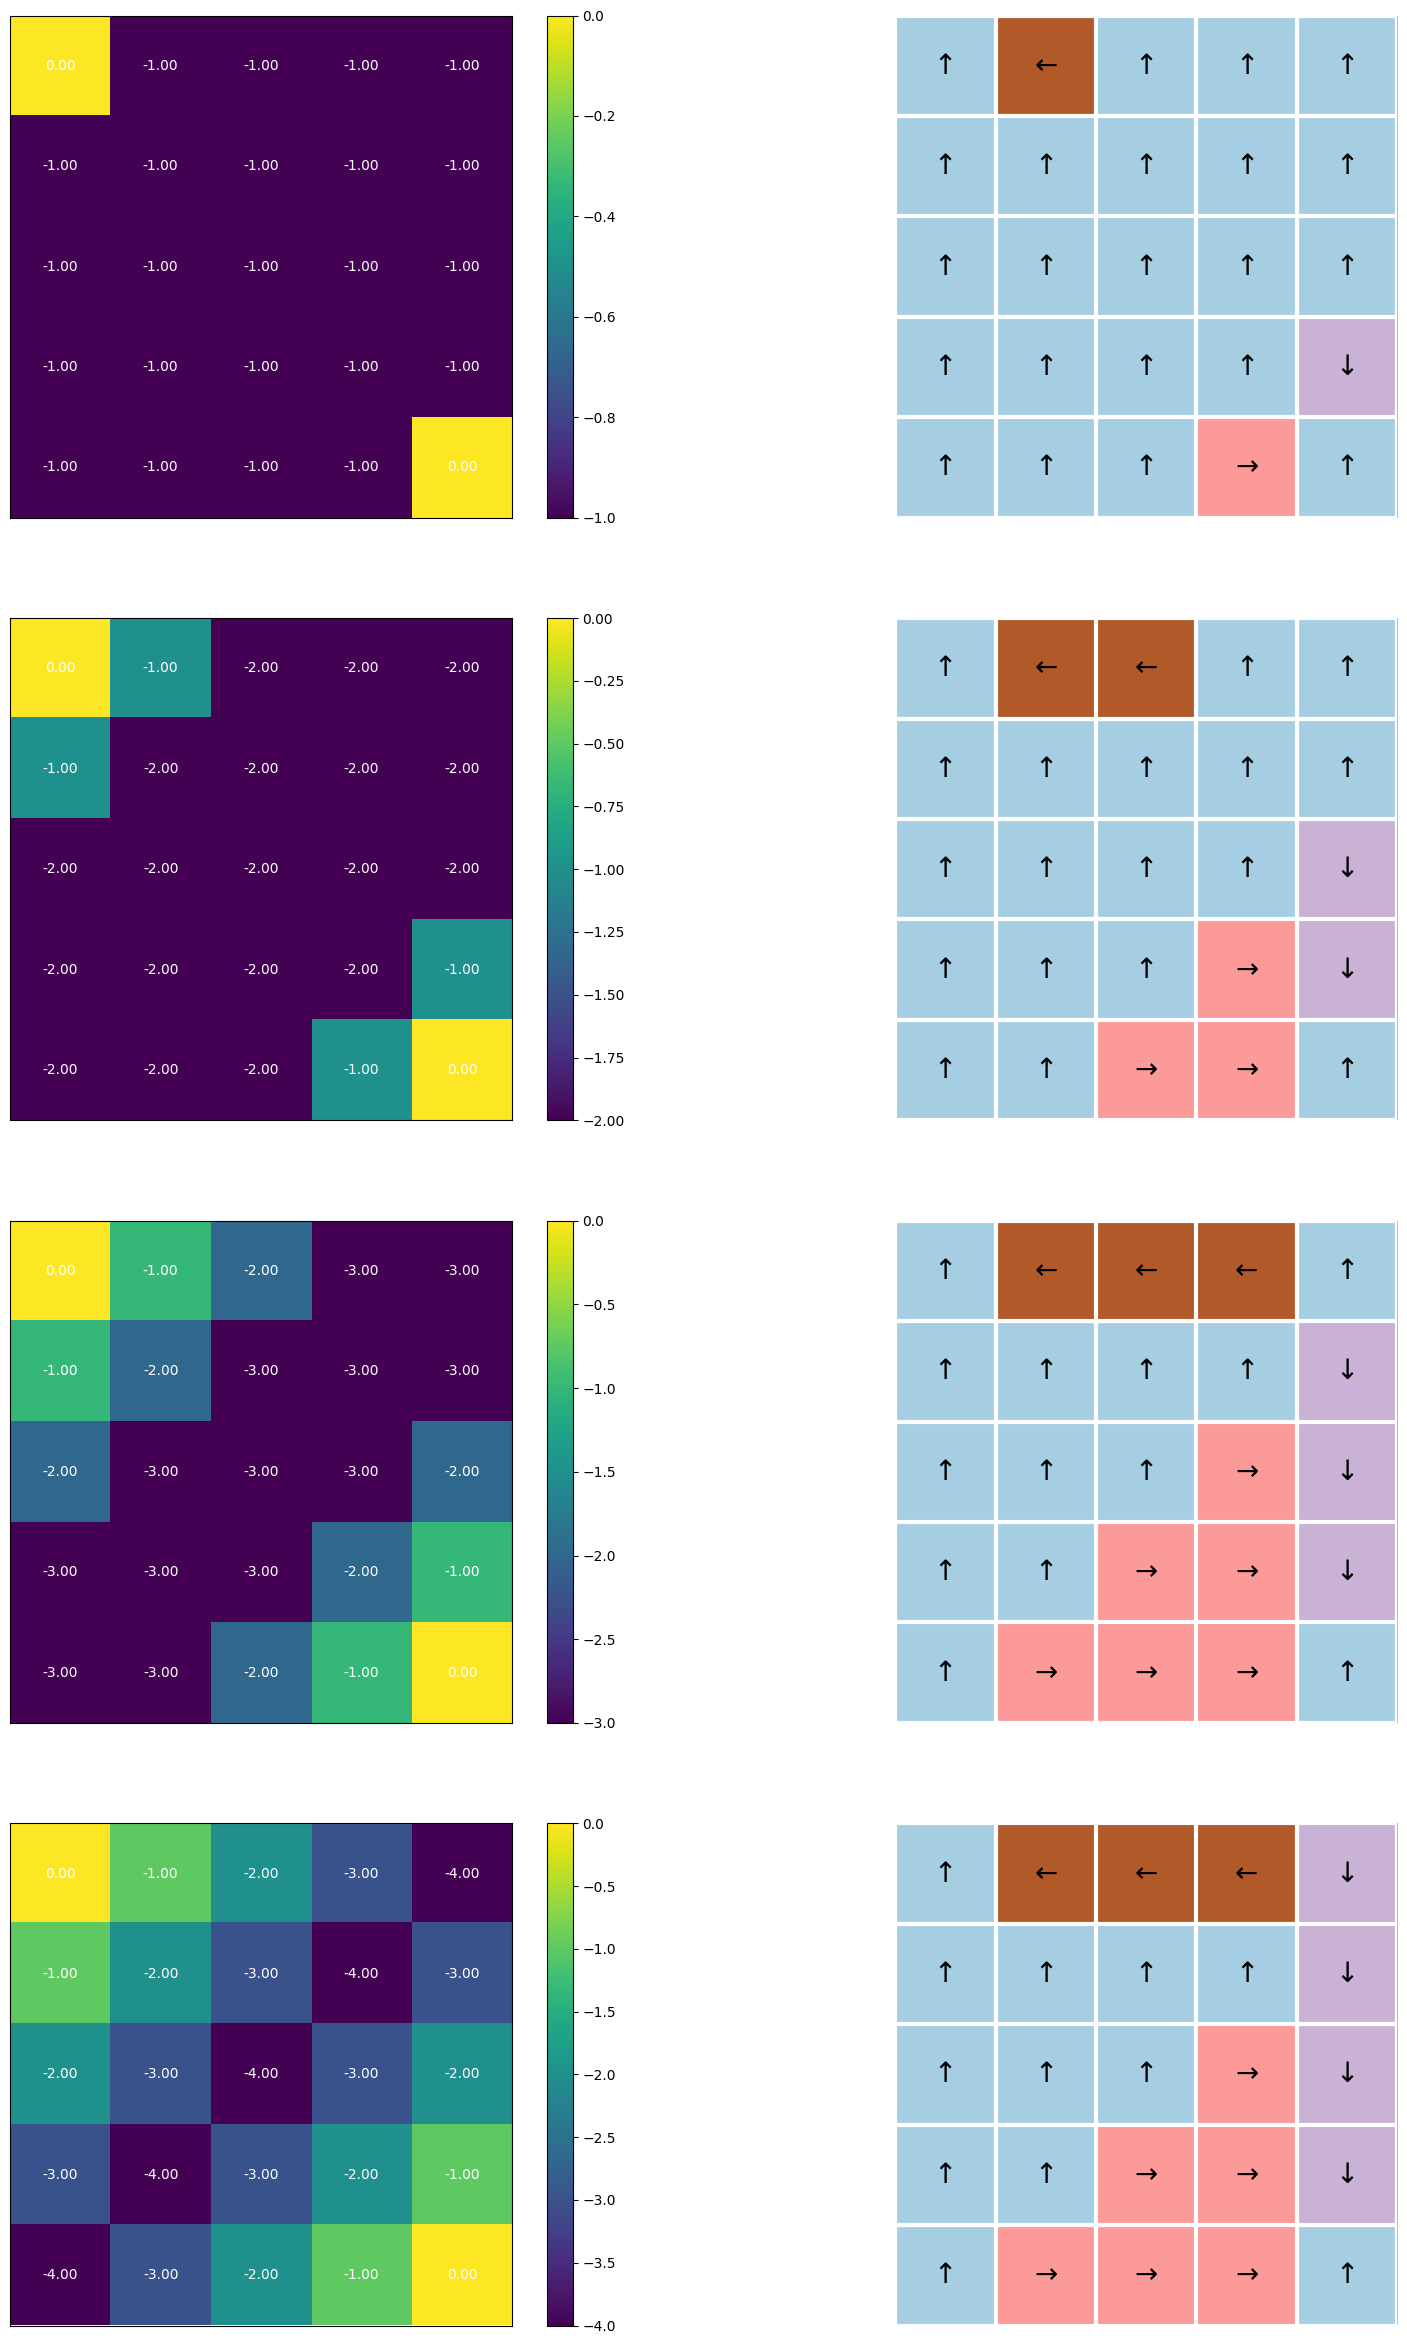

In [8]:
figsize_mul = 10
steps = info_ps_vi['step']

fig, ax = plt.subplots(nrows=steps, ncols=2, 
                       figsize=(steps * figsize_mul * 0.5, figsize_mul* 3))
for i in range(steps):
    visualize_value_function(ax[i][0],info_ps_vi['v'][i], nx, ny)
    visualize_policy(ax[i][1], info_ps_vi['pi'][i], nx, ny)    

## One more thing! Full sweeping이 아니어도 수렴할까?

여태까지 살펴본 비동기적 DP 알고리즘들은 비동기적으로 업데이트를 하지만 매 value iteration 마다 모든 
$(s)$ 및 $(s,a)$에 대해서 업데이트 해주는 방식인 __Full sweeping__ 을 사용하였습니다.

하지만, __Full sweeping__ 상당히 비현실적입니다. 

차후에 수업에서 자세히 배우겠지만, RL알고리즘들은 DP의 Policy evaludation, Policy iteration, Value iteration 들을 환경과의 상호작용을 통해 얻은 sameple로 근사적으로 수행합니다. 따라서 RL 알고리즘의 관점에서 __Full sweeping__ 은 매우 비현실적인 상황이 됩니다. 

> RL 알고리즘이 __Full sweeping__ 을 하려면 매번 엄청난 수의 샘플이 필요하겠죠. <br>
> 추가적으로 매 가치평가마다 모든 $(s)$ 및 $(s,a)$ 을 방문한다는 가정도 필요합니다.

그렇다면, 매 가치반복의 알고리즘의 스텝마다 모든 $(s)$를 업데이트 하지 않아도 비동기적 가치반복 알고리즘은 수렴할까요?

> "특정 조건" 이 맞춰지면, 모든 $(s)$를 업데이트 하지 않아도 비동기적 가치반복 알고리즘은 수렴!
> "특정 조건" 은 간략하게 말하면, "모든 가치반복 업데이트동안에, 모든 $s$가 업데이트 된다" 입니다.

기존의 Full sweeping 은 매 가치반복 업데이트 `내에서` 모든 $s$를 업데이트 해야했지만,
지금 부터 살펴볼 Partial sweeping 에서는 모든 가치반복 업데이트 `중에서`, 모든 $s$를 업데이트 하는 조건을 만족시킵니다.

## (3) Parital sweeping VI

Parital sweeping VI 의 개념을 확인하기 위해 간단한 메서드를 하나 준비했습니다.
새로운 메서드 `in_place_vi_partial_update()`는 `update_prob`, `vi_iters` 를 인자로 받습니다.


> `update_prob` 는 한 가치반복 업데이트동안에 얼마의 확률로 state를 업데이트할지를 결정하는 인자입니다. 예를 들어 `update_prob=1.0`이 되면, 모든 $s$ 를 업데이트하게 됩니다. 혹은`update_prob=0.1`을 주게되면 전체 $\cal{S}$ 중 대략적으로 10% 에 해당하는 $s$ 들만 업데이트하게 됩니다.

> `vi_iters` 는 몇번의 가치반복 업데이트를 수행할지에 대한 인자입니다. 기존의 VI들은 수렴할때까지 반복했지만, 이번 경우는 여러분들의 학습의 목적으로 외부적으로 반복횟수를 설정할 수 있게 했습니다.

```python
    def in_place_vi_partial_update(self,
                                   v_init=None,
                                   update_prob=0.5,
                                   vi_iters: int = 100):
        """
        :param v_init: (np.array) initial value 'guesstimation' (optional)
        :return:
        """

        if v_init is not None:
            value = v_init
        else:
            value = np.zeros(self.ns)

        info = dict()
        info['v'] = list()
        info['pi'] = list()
        info['gap'] = list()

        # loop over value iteration:
        # perform the loop until the value estimates are converge
        for steps in range(vi_iters):
            # loop over states:
            # we perform 'sweeping' over states in "any arbitrary" order.
            # without-loss-of-generality, we can perform as the order of states.
            # in this example, we consider the "full sweeping" of values.

            # perform in-place VI
            delta_v = 0

            for s in range(self.ns):
                perform_update = np.random.binomial(size=1, n=1, p=update_prob)
                if not perform_update:
                    continue

                # Bellman expectation backup of current state in in-place fashion
                # get Q values of given state 's'
                qs = self.compute_q_from_v(value)[:, s]
                v = qs.max(axis=0)  # get max value along the actions

                # accumulate the deviation from the current state s
                # the deviation = |v_new - v|
                delta_v += np.linalg.norm(value[s] - v)
                value[s] = v
            info['gap'].append(delta_v)
            info['v'].append(value.copy())
            pi = self.construct_policy_from_v(value)
            info['pi'].append(pi)

        return info
```


In [9]:
info_ip_partial_vi = asyncDPagent.in_place_vi_partial_update(update_prob=0.2, 
                                                             vi_iters=100)

In [10]:
steps = len(info_ip_partial_vi['v'])
viz_every = 20
n_figs = steps // viz_every

n_cols = 4
if n_figs % n_cols == 0:
    n_rows = n_figs // n_cols
else:
    n_rows = n_figs // n_cols + 1


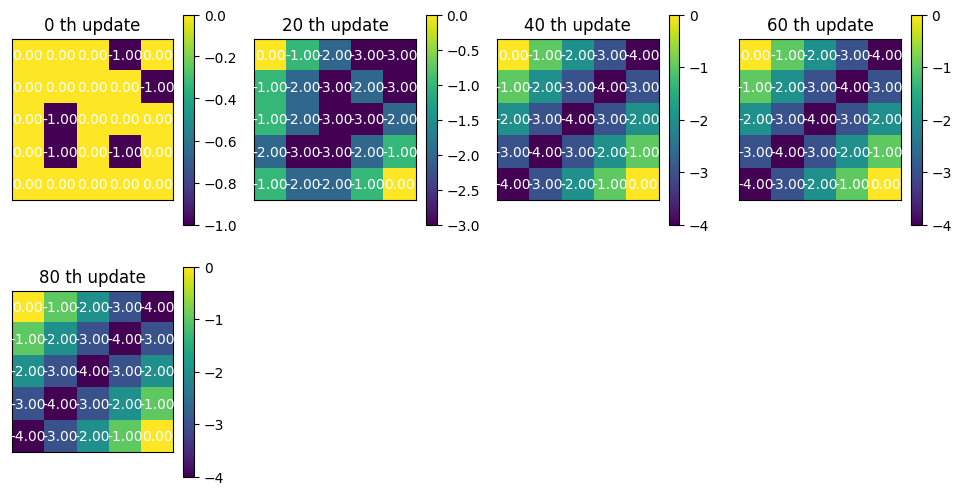

In [11]:
fig, ax = plt.subplots(n_rows,n_cols, figsize=(n_cols*3, n_rows*3))
ax = ax.reshape(-1)
for i in range(n_figs):
    
    viz_i = i * viz_every
    visualize_value_function(ax[i],info_ip_partial_vi['v'][viz_i], nx, ny)
    ax[i].set_title("{} th update".format(viz_i))

for off_idx in range(n_figs, n_rows*n_cols):
    ax[off_idx].axis('off')

In [12]:
info_ip_partial_vi = asyncDPagent.in_place_vi_partial_update(update_prob=0.01, 
                                                             vi_iters=1500)

In [15]:
steps = len(info_ip_partial_vi['v'])
viz_every = 100
n_figs = steps // viz_every

n_cols = 4
if n_figs % n_cols == 0:
    n_rows = n_figs // n_cols
else:
    n_rows = n_figs // n_cols + 1

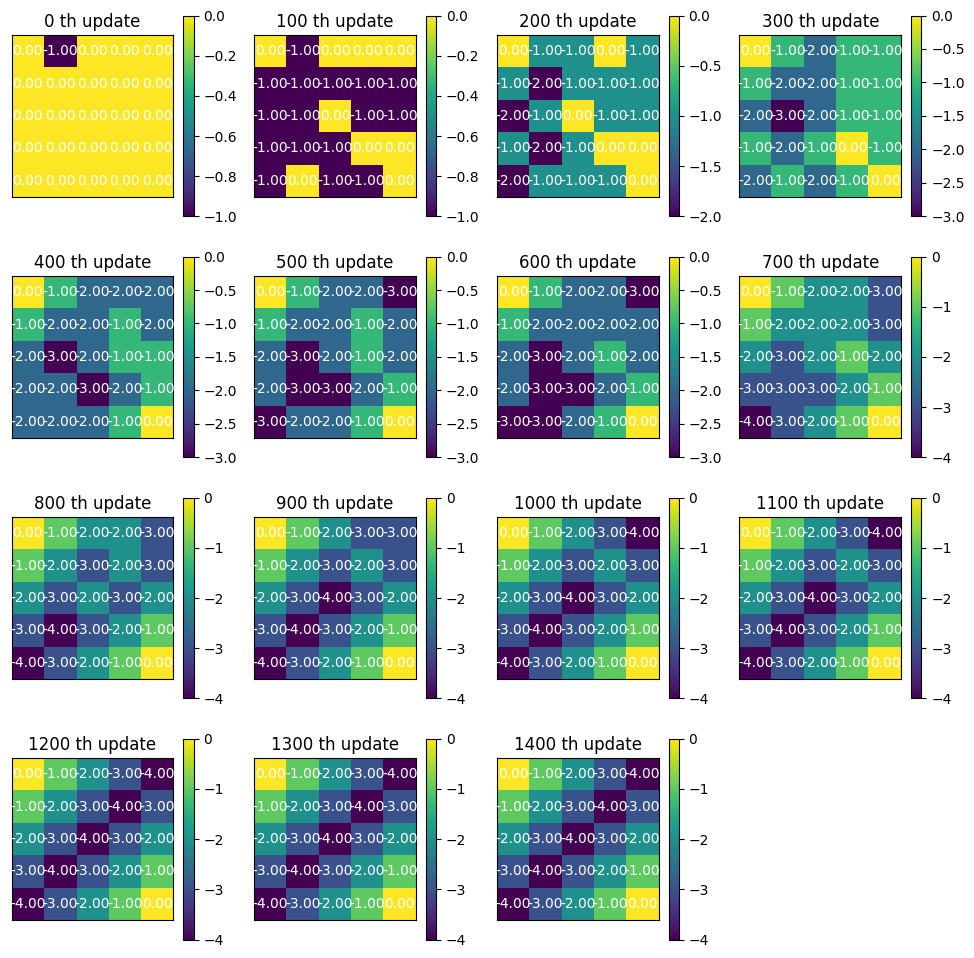

In [16]:
fig, ax = plt.subplots(n_rows,n_cols, figsize=(n_cols*3, n_rows*3))
ax = ax.reshape(-1)
for i in range(n_figs):
    
    viz_i = i * viz_every
    visualize_value_function(ax[i],info_ip_partial_vi['v'][viz_i], nx, ny)
    ax[i].set_title("{} th update".format(viz_i))

for off_idx in range(n_figs, n_rows*n_cols):
    ax[off_idx].axis('off')